## Import Required libraries

In [243]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LeakyReLU, LSTM
from tensorflow.keras.regularizers import l2

## Data Preprocessing

In [246]:
# Load the dataset
df = pd.read_csv("imdb_reviews.csv") 
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [248]:
df.shape

(50000, 2)

In [250]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [233]:
print(df.isnull().sum())  # Check missing values in each column

review       0
sentiment    0
dtype: int64


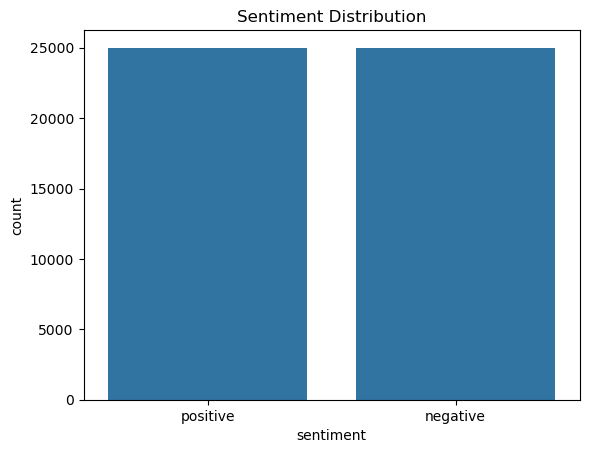

In [227]:
# Check for Sentiment distribution through the dataset
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()

In [228]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [231]:
# Turning sentiment(postive, negative) values to 0,1
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

print(df['sentiment'].value_counts())  

sentiment
1    25000
0    25000
Name: count, dtype: int64


In [235]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Processing text using nltk(Removing stopwords,unwanted signs)

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str): 
        return ""  

    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    words = word_tokenize(text) 
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)


In [237]:
df['processed_review'] = df['review'].apply(preprocess_text)

In [29]:
print(df['processed_review'].head())

0    one reviewers mentioned watching 1 oz episode ...
1    wonderful little production br br filming tech...
2    thought wonderful way spend time hot summer we...
3    basically theres family little boy jake thinks...
4    petter matteis love time money visually stunni...
Name: processed_review, dtype: object


In [32]:
df.head()

,review,sentiment,processed_review
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,1,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love time money visually stunni...


In [34]:
# Split data into training & testing sets
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    df['processed_review'], df['sentiment'], test_size=0.2, random_state=42
)

In [36]:
# Tokenize the text
vocab_size = 5000  # Maximum unique words
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)

In [38]:
# Convert text into sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

In [40]:
# Pad sequences to ensure uniform length
from keras.preprocessing.sequence import pad_sequences
max_length = 200  # Max length of a review
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post")

In [42]:
# Load Pre-trained GloVe Embeddings
embedding_dim = 100  
glove_path = "glove.6B.100d.txt"  

# Load embeddings into dictionary
embedding_index = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coef = np.array(values[1:], dtype=np.float32)
        embedding_index[word] = coef

# Create Embedding Matrix
word_index = tokenizer.word_index  
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Embedding Matrix Shape:", embedding_matrix.shape)


Embedding Matrix Shape: (5000, 100)


## Model Selection

In [167]:

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True),
    LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, kernel_regularizer=l2(0.0001), activation='relu'),
    Dropout(0.35),
    Dense(32, kernel_regularizer=l2(0.0001), activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

## Model Trainning

In [169]:
# Using Adam as optimizer with accuracy for validation
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [171]:
# Print summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 500,000 (1.91 MB)

 Trainable params: 500,000 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

In [173]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stop=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [175]:
history = model.fit(train_padded, train_labels, epochs=15, validation_data=(test_padded, test_labels), batch_size=64, callbacks=[early_stop])

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 95ms/step - accuracy: 0.5121 - loss: 0.7007 - val_accuracy: 0.5183 - val_loss: 0.6968
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.5372 - loss: 0.6879 - val_accuracy: 0.5473 - val_loss: 0.6695
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 117ms/step - accuracy: 0.5675 - loss: 0.6679 - val_accuracy: 0.7414 - val_loss: 0.5476
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 104s 166ms/step - accuracy: 0.7777 - loss: 0.5187 - val_accuracy: 0.8546 - val_loss: 0.3679
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 139s 161ms/step - accuracy: 0.8118 - loss: 0.4508 - val_accuracy: 0.8461 - val_loss: 0.3845
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 159ms/step - accuracy: 0.8588 - loss: 0.3598 - val_accuracy: 0.8740 - val_loss: 0.3145
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 157ms/step - accuracy: 0.8764 - loss: 0.3182 - val_accuracy: 0.8804 - val_loss: 0.2940
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - accuracy: 0.8868 - loss:

## Model Evaluation

In [177]:
# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8955 - loss: 0.2581
Test Accuracy: 89.61%


In [154]:
%matplotlib inline

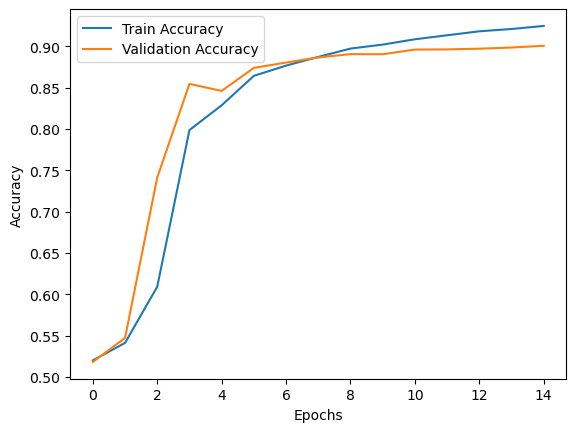

In [179]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

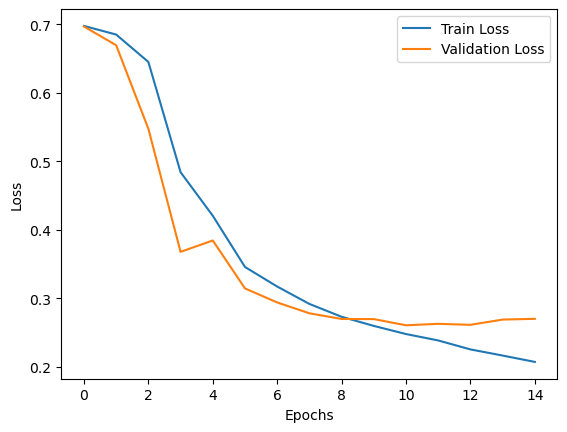

In [181]:
# Visualize the loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [185]:
from sklearn.metrics import roc_curve, auc

# Get model predictions
y_pred_prob = model.predict(test_padded)  

# Computing False Positive Rate (FPR), True Positive Rate (TPR)
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)  


roc_auc = auc(fpr, tpr)
print(f"ROC-AUC Score: {roc_auc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
ROC-AUC Score: 0.9616


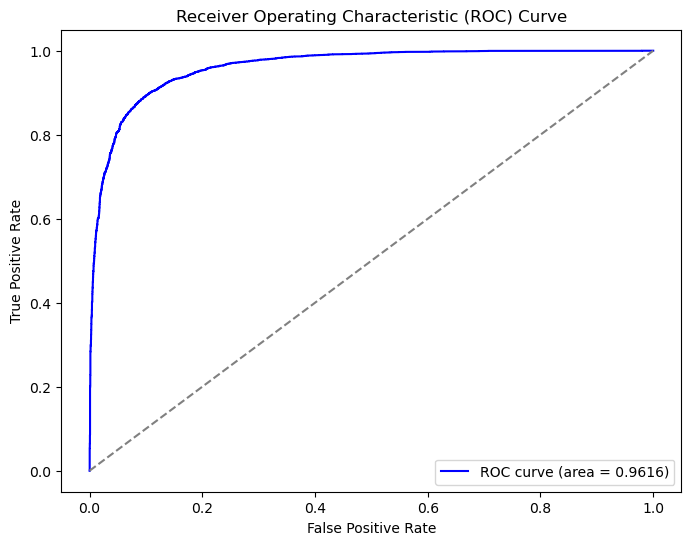

In [189]:
# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Testing with new reviews

In [215]:
# Making Predictions on New Reviews
def predict_sentiment(review):
    sequence = tokenizer.texts_to_sequences([review])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding="post")
    prediction = model.predict(padded_sequence)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    confidence = prediction if prediction > 0.5 else (1 - prediction)
    return f"{sentiment} ({confidence:.2f})"

In [258]:
review_1 = """I had high hopes for this film, but unfortunately, it was a complete letdown. The storyline was all over the place, 
making it difficult to stay engaged. The acting felt forced, and the dialogue was cringe-worthy at best. The pacing was terrible, 
dragging on in some parts and rushing through others. The cinematography was nothing special, and the soundtrack felt out of place. 
By the time the movie ended, I was left wondering why I had wasted two hours of my life. Definitely not something I would recommend."""


print(f"Review Sentiment: {predict_sentiment(review_1)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Review Sentiment: Negative (0.96)


In [260]:
review_2 = """From the moment the movie started, I was completely captivated. The cinematography was breathtaking, every frame felt like a painting. 
The performances were raw and emotional, making me feel deeply connected to the characters. The story was well-paced, with just the right amount of
suspense and drama. The soundtrack complemented the scenes beautifully, enhancing the emotional depth of the film. I found myself completely 
immersed in the world it created, and by the end, I was left speechless. This is undoubtedly one of the best movies I have seen in years! """

print(f"Review Sentiment: {predict_sentiment(review_2)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Review Sentiment: Positive (0.97)
